Import libraries

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

#HClustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

#Kmeans
from sklearn.cluster import KMeans

#DBSCAN
from sklearn.cluster import DBSCAN


Load data

In [45]:
path = "../8CPU_20RAM/3600s/A1_100-A2_100-A3_100/merged2.csv"
df = pd.read_csv(path).dropna(inplace=False)

#timestamp remove
#df = df.iloc[:,1:]

if not "merge" in path:
    df = df.iloc[:,1:]
else:
    df = df.iloc[:,2:]

#methods.csv
if "methods" in path:
    endpoint_map = {
        'do-register': 0,
        'add-sell-offer': 1,
        'add-buy-offer': 2,
        'get-stock-data': 3,
        'add-company': 4,
        'get-stock-users-and-companies': 5

    }
    # zastosowanie mapowania na kolumnę endpointUrl
    df['endpointUrl'] = df['endpointUrl'].replace(endpoint_map)

#
if 'replicaId' in df.columns:
    df['replicaId'] = pd.factorize(df['replicaId'])[0]


# zaokrąglij dane procentowe zużycia do dwóch miejsc po przecinku
cols_to_round = [col for col in df.columns if 'memoryUsage' in col or 'cpuUsage' in col]
if cols_to_round:
    df[cols_to_round] = df[cols_to_round].round(2)




Drop features that are not usable

In [46]:
df = df.drop(["queueSizeForward"], axis=1);

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   st_cpuUsage              310 non-null    float64
 1   st_memoryUsage           310 non-null    float64
 2   apiTime                  310 non-null    int64  
 3   applicationTime          310 non-null    int64  
 4   databaseTime             310 non-null    int64  
 5   endpointUrl              310 non-null    int64  
 6   queueSizeBack            310 non-null    int64  
 7   trad_applicationTime     310 non-null    int64  
 8   trad_databaseTime        310 non-null    int64  
 9   trad_numberOfSellOffers  310 non-null    int64  
 10  trad_numberOfBuyOffers   310 non-null    int64  
 11  traf_cpuUsage            310 non-null    float64
 12  traf_memoryUsage         310 non-null    float64
dtypes: float64(4), int64(9)
memory usage: 31.6 KB


Plotting simple histograms of remaining column values

C:\Users\kalon\AppData\Local\Temp\ipykernel_13036\3583888619.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax = ax)


array([[<AxesSubplot:title={'center':'st_cpuUsage'}>,
        <AxesSubplot:title={'center':'st_memoryUsage'}>,
        <AxesSubplot:title={'center':'apiTime'}>,
        <AxesSubplot:title={'center':'applicationTime'}>],
       [<AxesSubplot:title={'center':'databaseTime'}>,
        <AxesSubplot:title={'center':'endpointUrl'}>,
        <AxesSubplot:title={'center':'queueSizeBack'}>,
        <AxesSubplot:title={'center':'trad_applicationTime'}>],
       [<AxesSubplot:title={'center':'trad_databaseTime'}>,
        <AxesSubplot:title={'center':'trad_numberOfSellOffers'}>,
        <AxesSubplot:title={'center':'trad_numberOfBuyOffers'}>,
        <AxesSubplot:title={'center':'traf_cpuUsage'}>],
       [<AxesSubplot:title={'center':'traf_memoryUsage'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

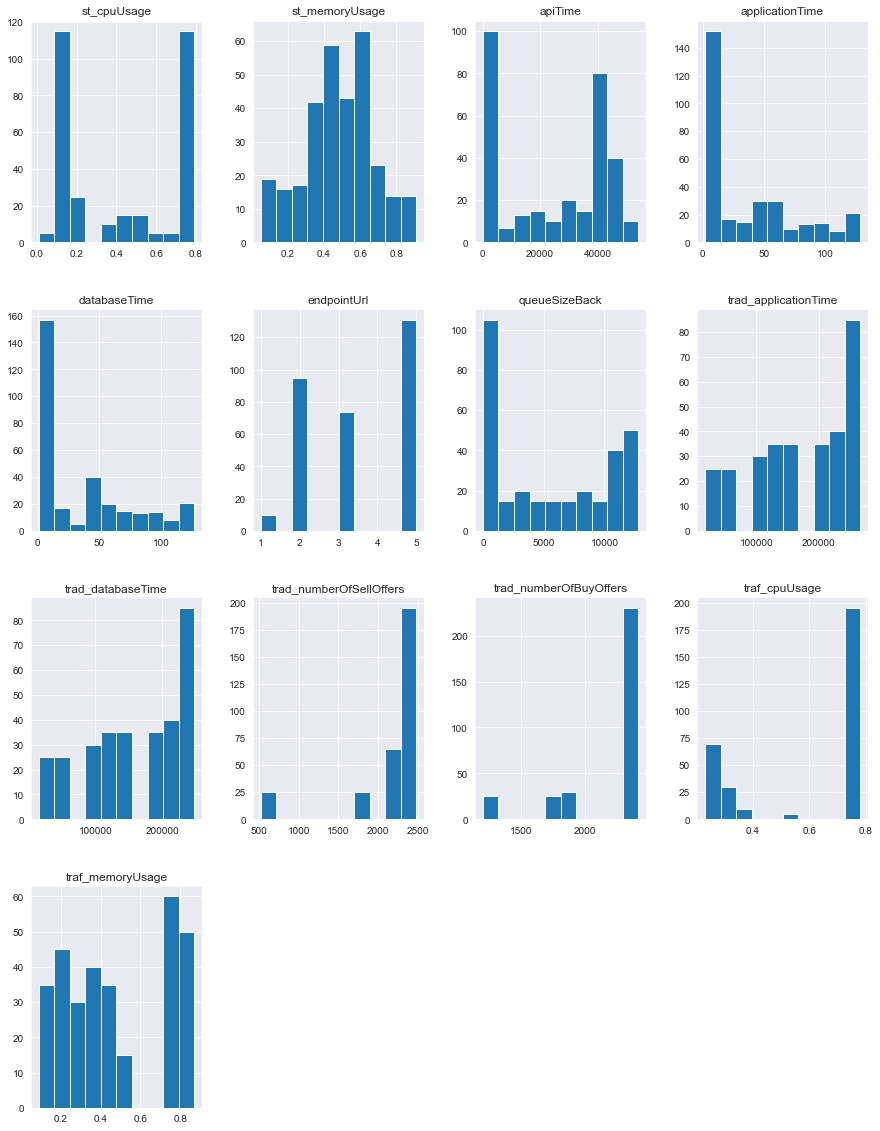

In [47]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df.hist(ax = ax)

Getting basic statistics

In [48]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
st_cpuUsage,310.0,0.422097,0.281559,0.01,0.14,0.385,0.74,0.79
st_memoryUsage,310.0,0.483645,0.193860,0.05,0.38,0.480,0.61,0.91
apiTime,310.0,24368.590323,19077.603651,13.00,153.00,29197.000,41389.00,54212.00
applicationTime,310.0,37.390323,40.203679,2.00,4.00,15.000,63.00,129.00
databaseTime,310.0,35.967742,40.013658,1.00,3.00,10.500,62.00,127.00
endpointUrl,310.0,3.474194,1.380978,1.00,2.00,3.000,5.00,5.00
queueSizeBack,310.0,5542.129032,4860.379025,0.00,0.00,5224.500,11300.00,12782.00
trad_applicationTime,310.0,173451.887097,79537.450922,17391.00,94810.00,210669.000,248266.00,266697.00
trad_databaseTime,310.0,161390.500000,74227.389740,15551.00,88259.00,196533.000,231345.00,247954.00
trad_numberOfSellOffers,310.0,2176.080645,519.093818,523.00,2118.00,2363.000,2451.00,2479.00


Pairplotting remaining columns to see any valuable pairs

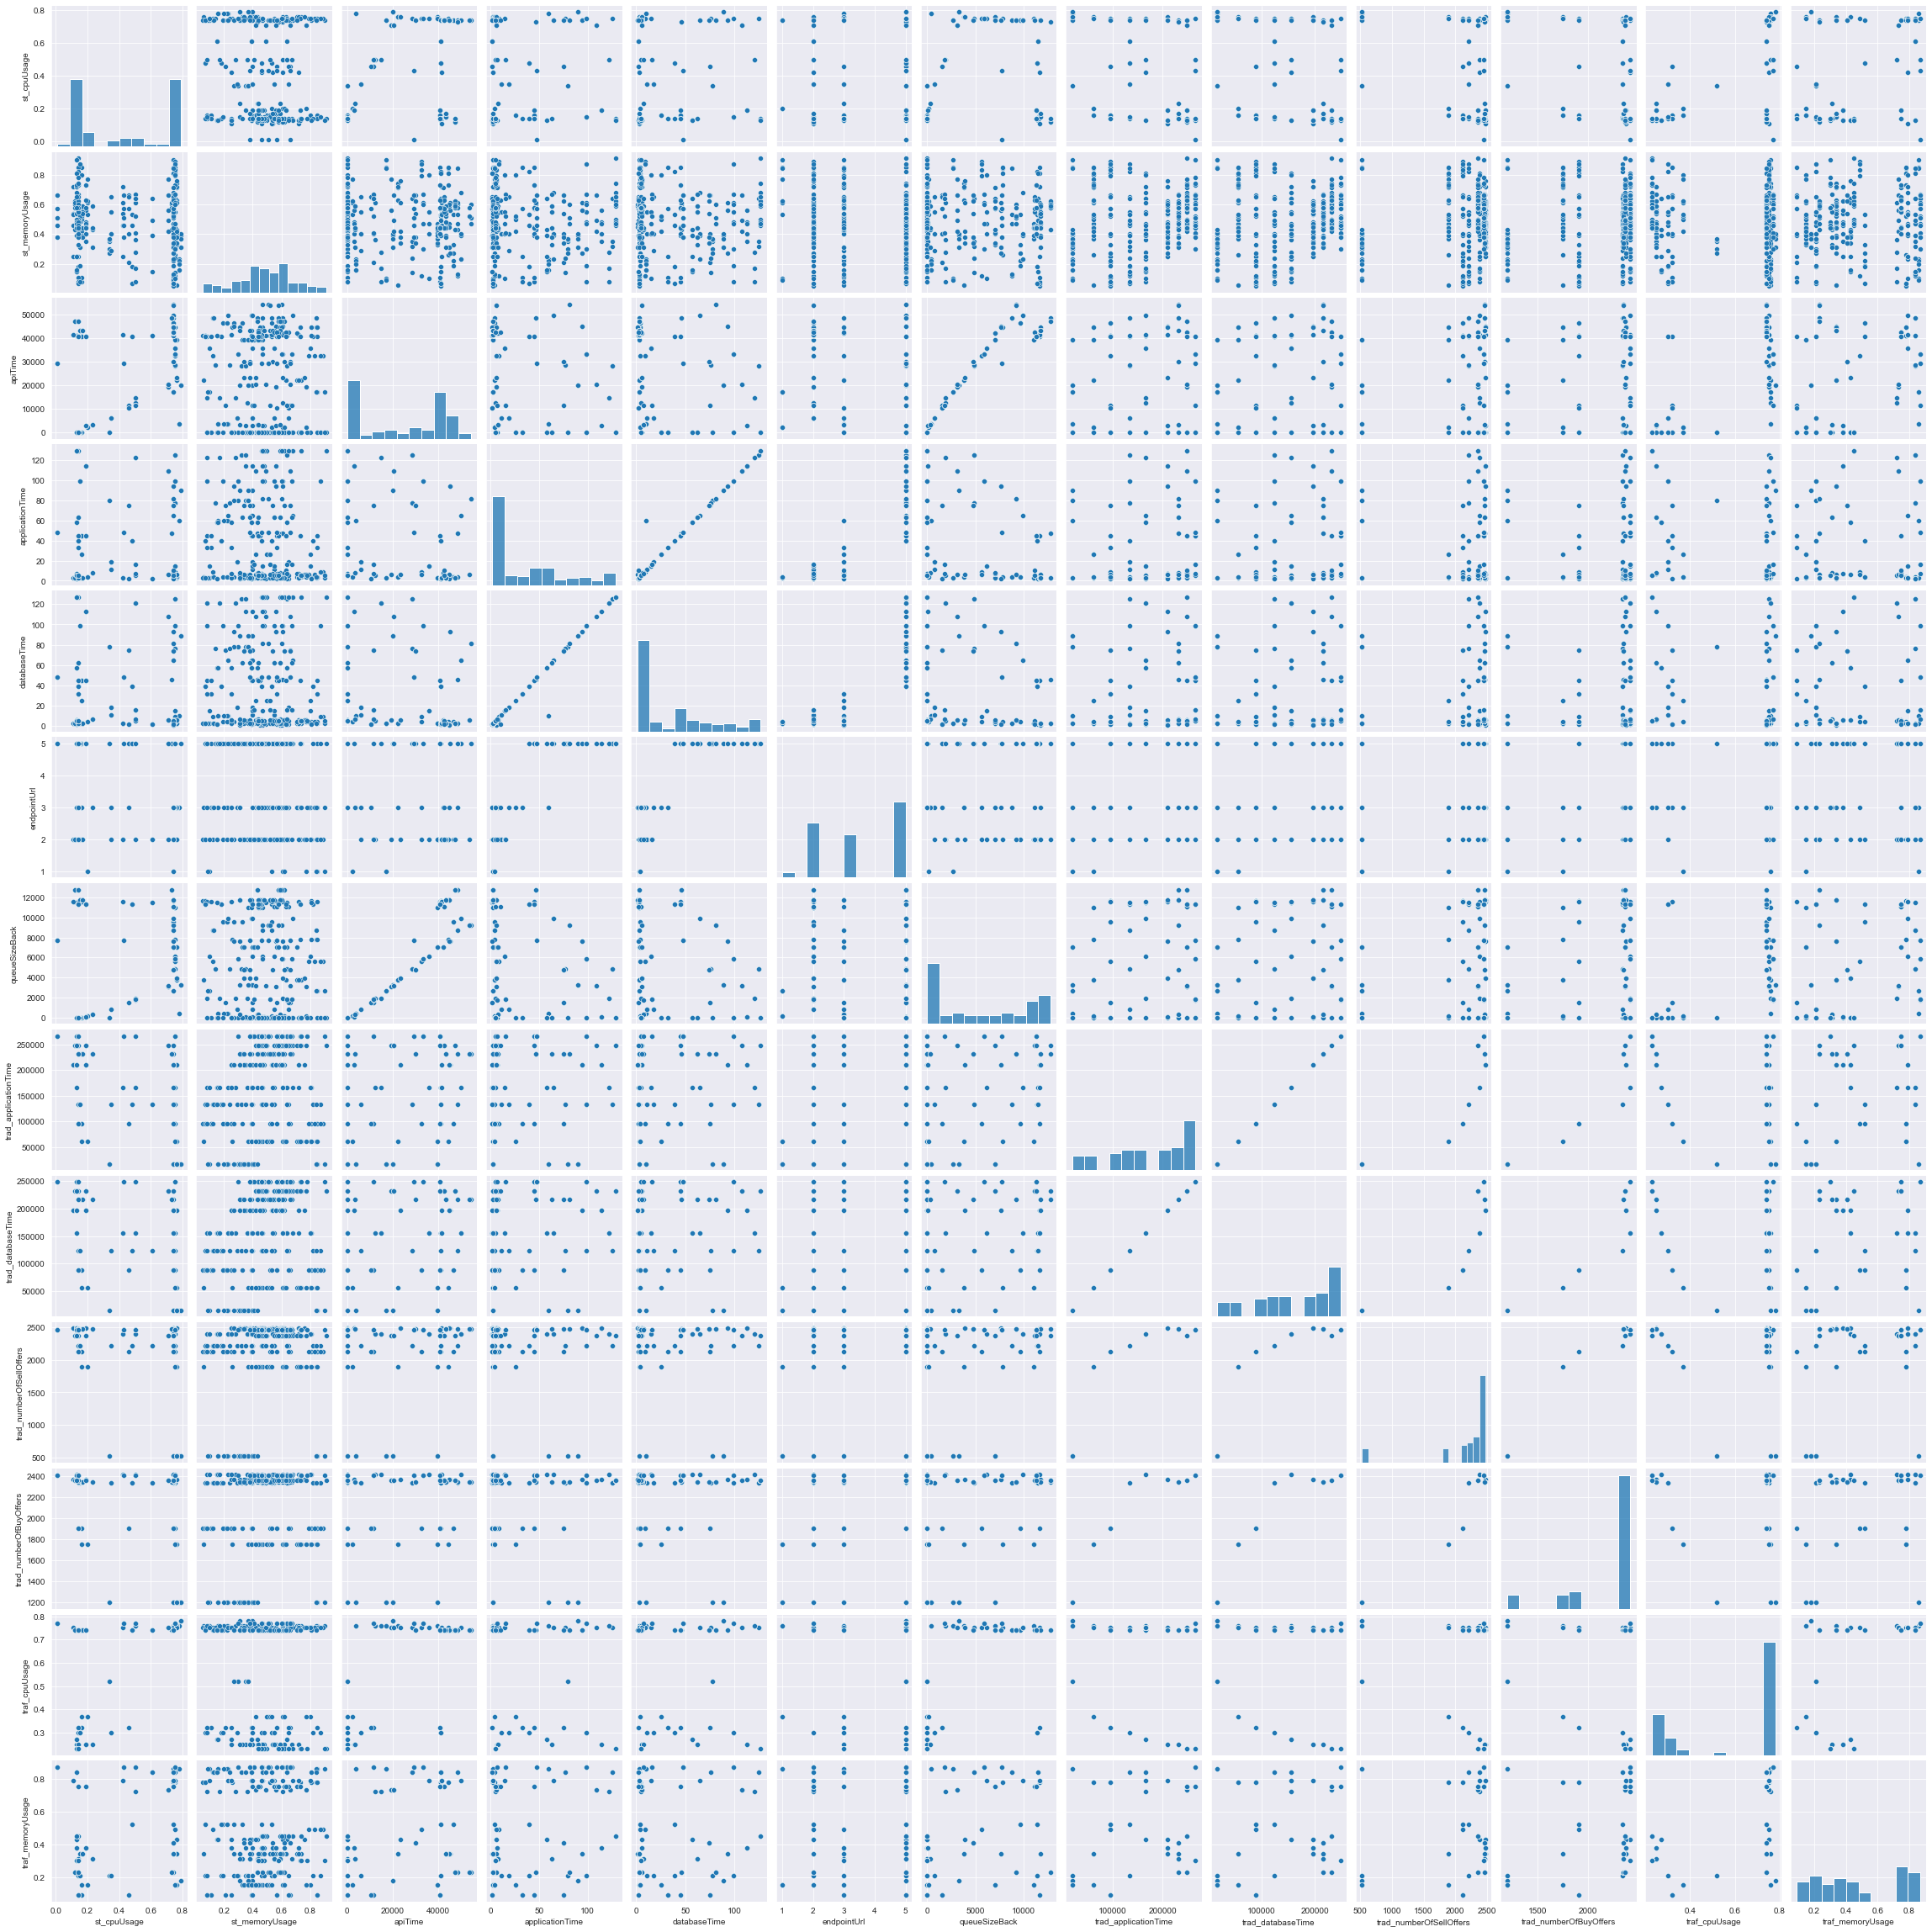

In [49]:
sb.pairplot(df)

Choosing pair of columns to analyze

<AxesSubplot:xlabel='traf_cpuUsage', ylabel='traf_memoryUsage'>

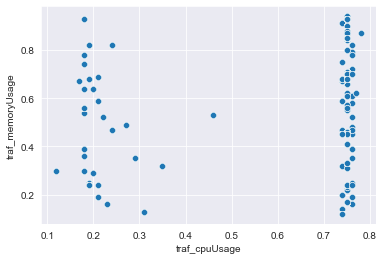

In [33]:
selected_data = df.filter(['st_cpuUsage', 'st_memoryUsage'])

sb.scatterplot(x=selected_data.iloc[:, 0],
               y=selected_data.iloc[:, 1])

Plotting dendogram to determine n# of clusters

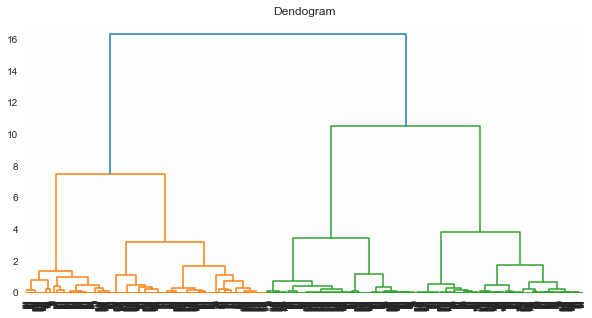

In [34]:
plt.figure(figsize=(10, 5))
plt.title("Dendogram")
clusters = shc.linkage(selected_data,
                       method='ward',
                       metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

Hierarchical CLustering

[1 1 1 ... 0 0 0]


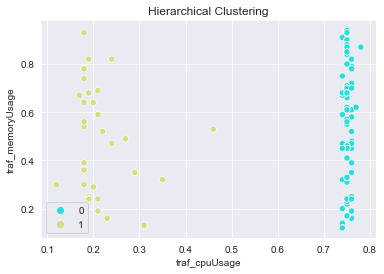

In [36]:
clustering_model = AgglomerativeClustering(
    n_clusters=2,
    affinity='euclidean',
    linkage='ward'
)

clustering_model.fit(selected_data)
print(clustering_model.labels_)

data_labels = clustering_model.labels_
hClusteringPlot = sb.scatterplot(x=selected_data.columns[0],
                                 y=selected_data.columns[1],
                                 data=selected_data,
                                 hue=data_labels,
                                 palette="rainbow").set_title('Hierarchical Clustering')


K-means

C:\Users\kalon\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

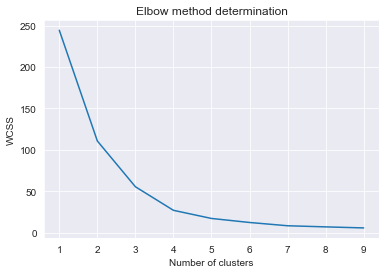

In [37]:
wcss = []
for i in range(1,10):
    kmeans = KMeans(
        n_clusters = i,
        init = 'k-means++',
        n_init = 10,
        max_iter = 500,
        random_state = 0,
    )
    kmeans.fit(selected_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,10), wcss)
plt.title('Elbow method determination')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show

K-means using predicted #n clusters

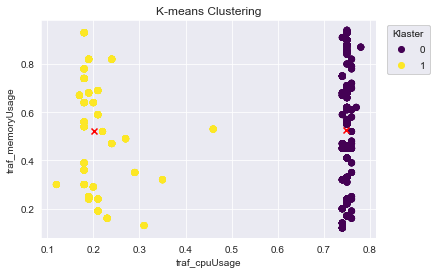

In [38]:
# Inicjalizacja algorytmu K-means
kmeans = KMeans(
    n_clusters = 2,
    init = 'k-means++',
    n_init = 10,
    max_iter = 500,
    random_state = 0,
)

# Dopasowanie k-means do danych wejściowych
kmeans.fit(selected_data)

# Przewidywanie przynależności klastra dla każdego punktu
labels = kmeans.predict(selected_data)

# Wyciąganie współrzędnych centroidów klastrów
centroids = kmeans.cluster_centers_

# Rysowanie wykresu
scatter = plt.scatter(selected_data.iloc[:, 0], selected_data.iloc[:, 1], c=labels, cmap='viridis')
centroids_plot = plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', label='Centroidy')  # Przypisanie rękojeści do zmiennej
plt.title('K-means Clustering')
plt.xlabel(selected_data.columns[0])
plt.ylabel(selected_data.columns[1])

# Tworzenie legendy z etykietami klastrów i centroidów
legend1 = plt.legend(*scatter.legend_elements(), title='Klaster', loc='upper right', bbox_to_anchor=(1.175, 1))
#plt.legend(handles=[centroids_plot], labels=['Centroidy'], loc='upper right', bbox_to_anchor=(1.25, 0.5))
plt.gca().add_artist(legend1)


plt.show()

DBSCAN

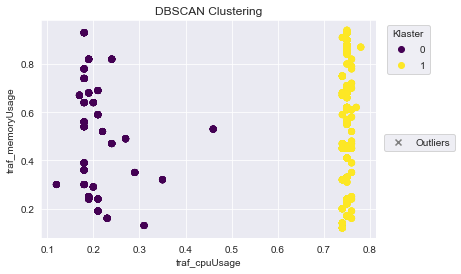

In [44]:
# Inicjalizacja algorytmu DBSCAN
dbscan = DBSCAN(eps=0.1, min_samples=5)  # Ustawienie odpowiednich parametrów: eps (promień otoczenia) i min_samples (minimalna liczba punktów w otoczeniu)

# Dopasowanie DBSCAN do danych wejściowych
labels = dbscan.fit_predict(selected_data)

# Wyciąganie współrzędnych punktów, które zostały przypisane do klastrów (ignorowanie punktów oznaczonych jako outlier-y)
clustered_points = selected_data[labels != -1]

# Wyciąganie współrzędnych punktów oznaczonych jako outlier-y
outlier_points = selected_data[labels == -1]

# Rysowanie wykresu
scatter = plt.scatter(clustered_points.iloc[:, 0], clustered_points.iloc[:, 1], c=labels[labels != -1], cmap='viridis')
outliers_plot = plt.scatter(outlier_points.iloc[:, 0], outlier_points.iloc[:, 1], c='gray', marker='x', label='Outliers')  # Przypisanie rękojeści do zmiennej
plt.title('DBSCAN Clustering')
plt.xlabel(selected_data.columns[0])
plt.ylabel(selected_data.columns[1])

# Tworzenie legendy z etykietami klastrów i outlier-ów
legend1 = plt.legend(*scatter.legend_elements(), title='Klaster', loc='upper right', bbox_to_anchor=(1.175, 1))
plt.legend(handles=[outliers_plot], labels=['Outliers'], loc='upper right', bbox_to_anchor=(1.25, 0.5))
plt.gca().add_artist(legend1)

plt.show()